In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing.frame
housing.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# housing.to_csv("/Users/kmalathkar/workspace/projects/machine-learning/data/housing.csv", index=False)

In [4]:
print(housing.shape)
housing.info()

(20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [6]:
housing.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

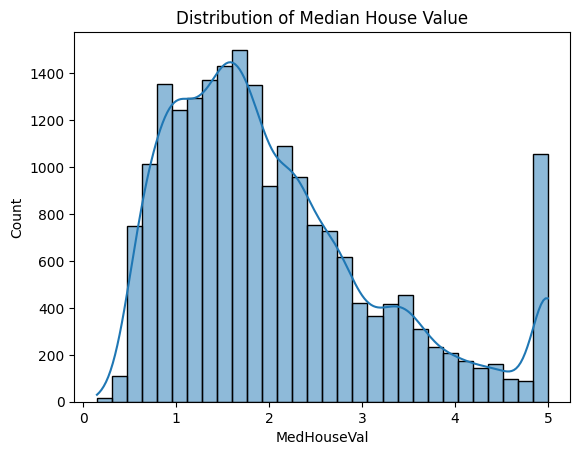

In [7]:
plt.Figure()
sns.histplot(data = housing, x = 'MedHouseVal', bins=30, kde=True)
plt.title('Distribution of Median House Value')
plt.show()

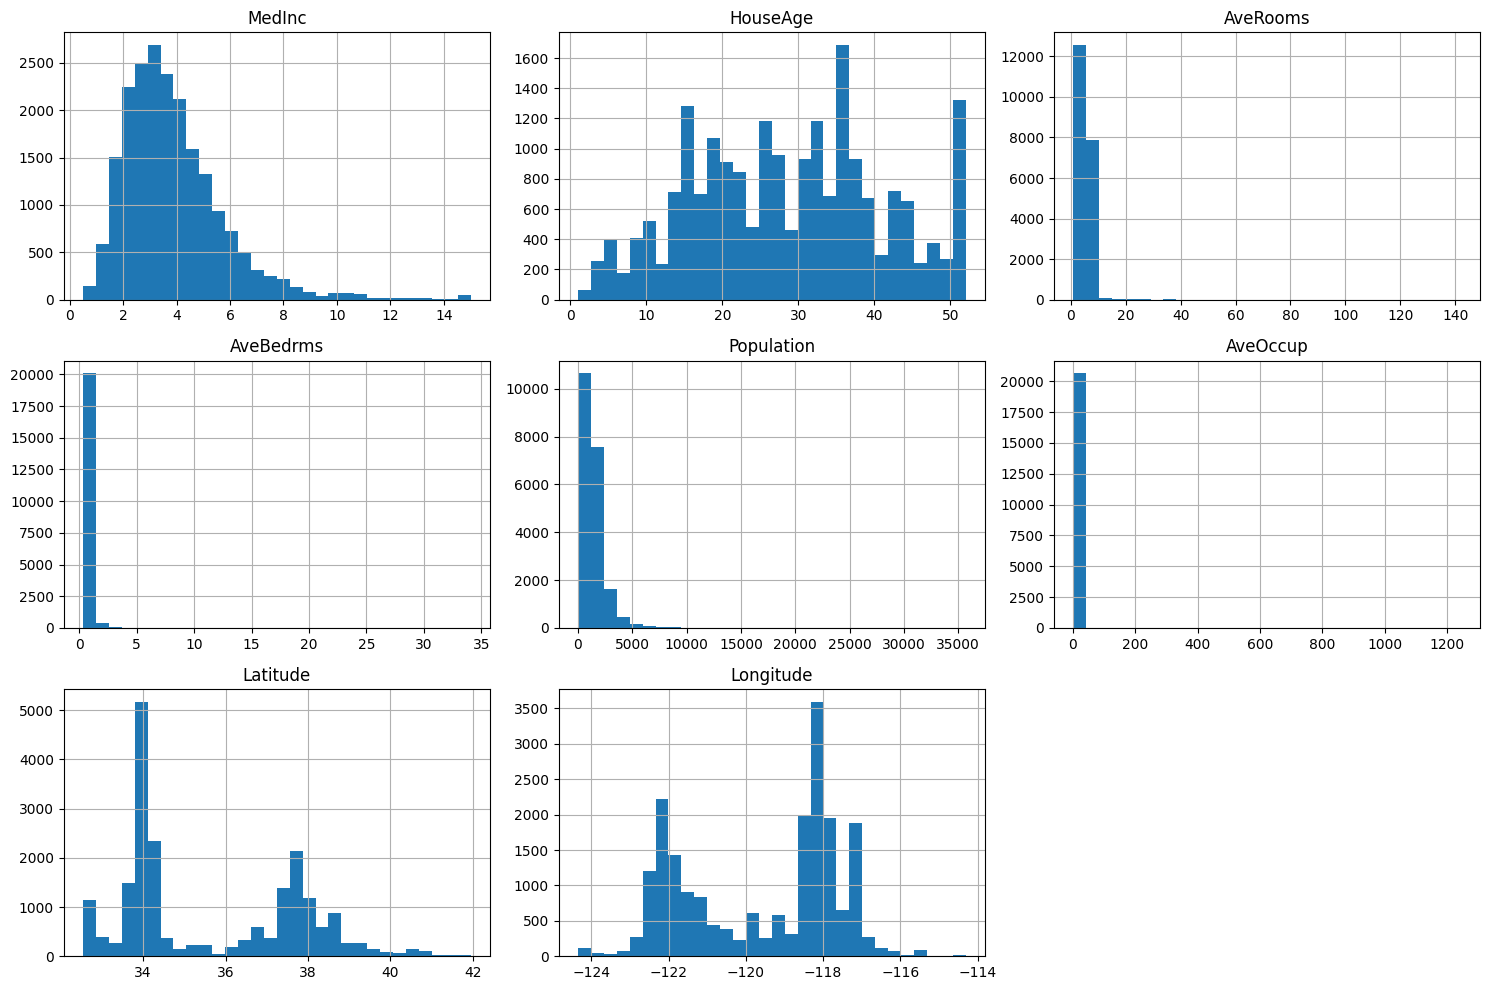

In [8]:
housing.drop(columns = 'MedHouseVal').hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.title('Feature Distributions')
plt.show()

* Heavy skew (AveRooms, AveBedrms, AveOccup)
* Different scales → need standardization

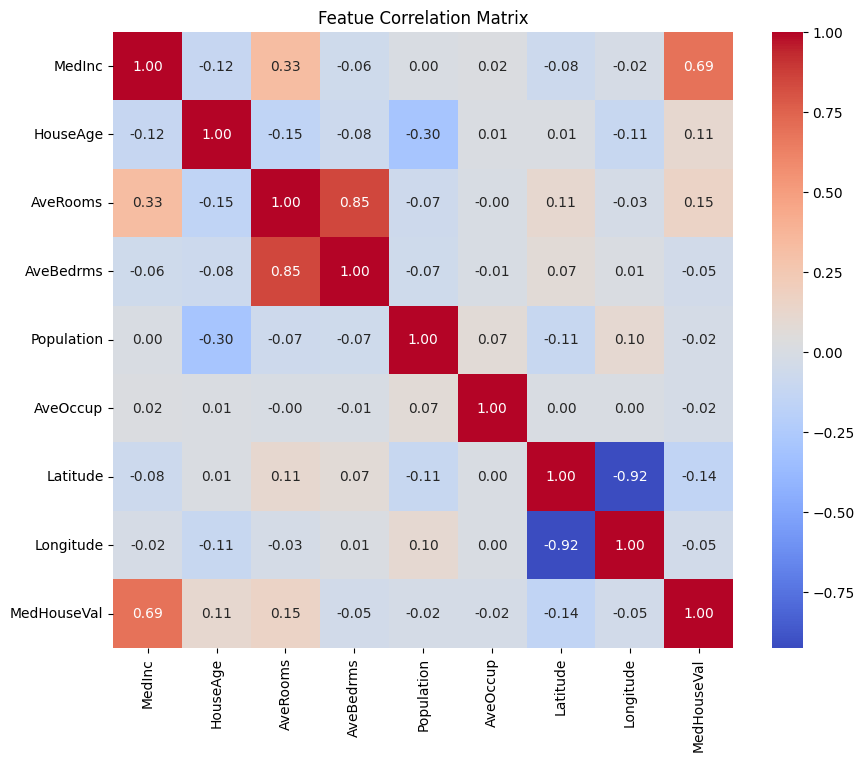

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(housing.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Featue Correlation Matrix')
plt.show()

 Income is the strongest predictor, while room-based features show multicollinearity, suggesting regularization may help

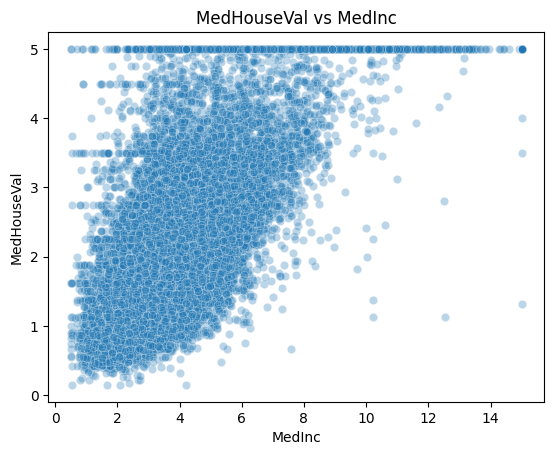

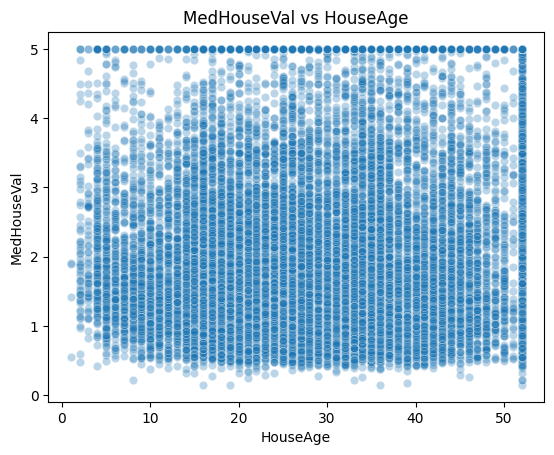

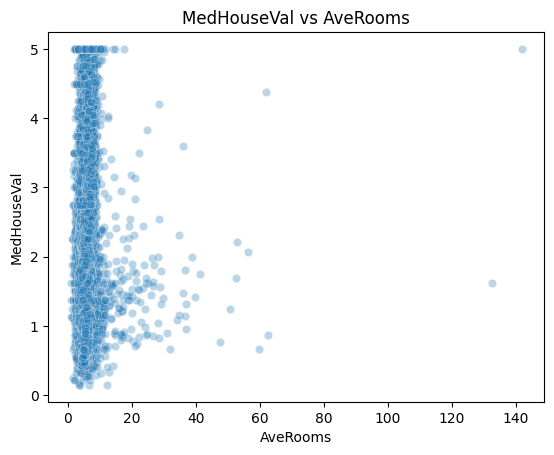

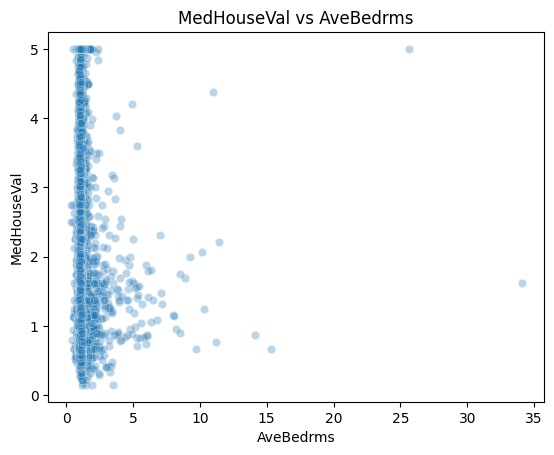

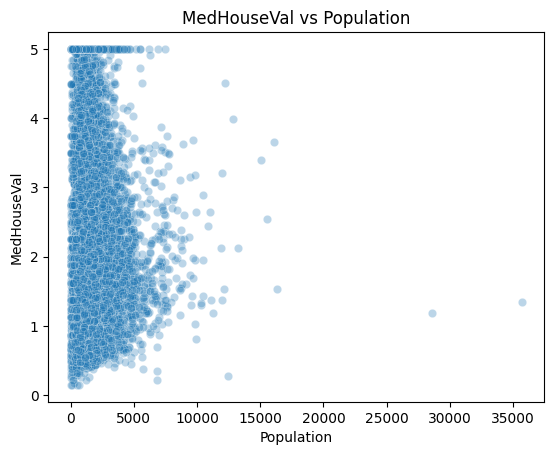

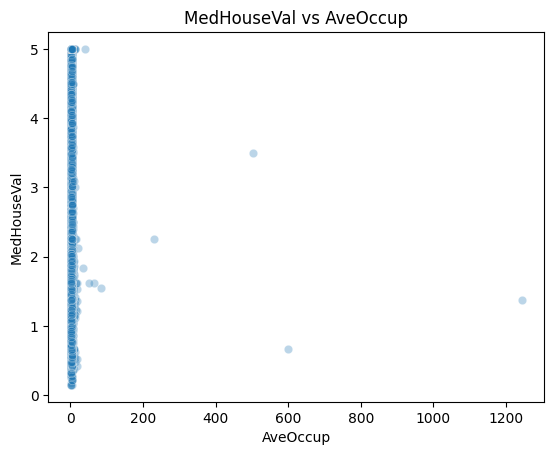

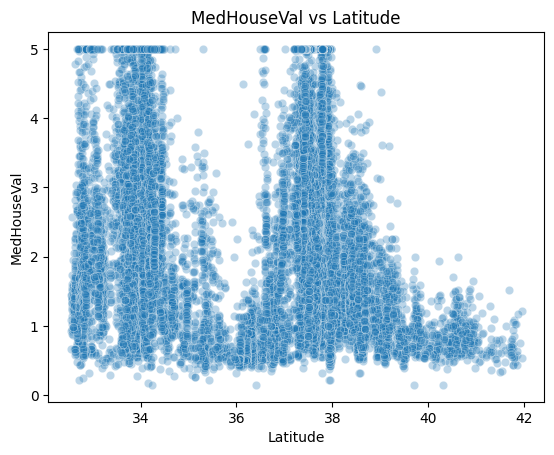

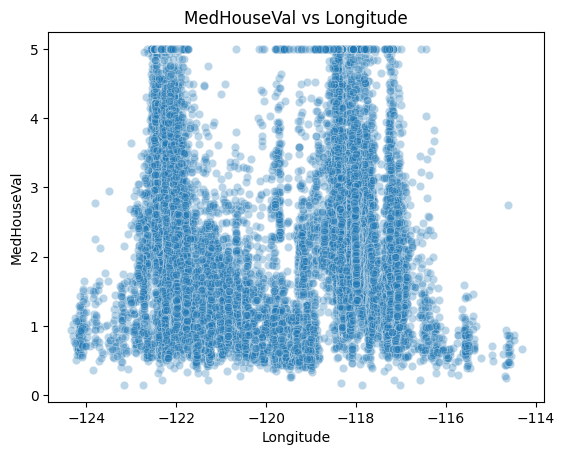

In [10]:
features = housing.drop(columns='MedHouseVal')
for col in features:
    plt.figure()
    sns.scatterplot(x=housing[col], y=housing['MedHouseVal'], alpha=0.3)
    plt.title(f'MedHouseVal vs {col}')
    plt.show()

### Observations:

* MedInc: roughly linear

* Others: nonlinear + heteroscedasticity

* Vertical banding near target cap

In [11]:
Q1 = housing.quantile(0.25)
Q3 = housing.quantile(0.75)
IQR = Q3 - Q1

outliers = ((housing < (Q1 - 1.5*IQR)) | (housing > (Q3 + 1.5*IQR))).sum()
outliers

MedInc          681
HouseAge          0
AveRooms        511
AveBedrms      1424
Population     1196
AveOccup        711
Latitude          0
Longitude         0
MedHouseVal    1071
dtype: int64

Several features contain extreme values; I’d consider log transforms or robust regression.

The California Housing dataset has no missing values but shows skewed distributions, scale differences, multicollinearity, and a capped target. Income is the strongest linear driver, while other features show nonlinear effects, suggesting feature transformations and regularization before modeling.

In [13]:
skewed_features = ["AveRooms", "AveBedrms", "Population", "AveOccup"]

housing_transformed = housing.copy()

for col in skewed_features:
    housing_transformed[col] = np.log1p(housing_transformed[col])


In [14]:
# Pipeline Construction and Model Training

X = housing_transformed.drop(columns="MedHouseVal")
y = housing_transformed["MedHouseVal"]

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

log_transformer = FunctionTransformer(np.log1p, validate=True)

preprocessor = ColumnTransformer(
    transformers = [
        ('log', log_transformer, skewed_features),
    ],
    remainder = 'passthrough'
)

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2,
        'Explained Variance Score': evs
    }

In [16]:
train_metrics = evaluate_model(y_train, y_train_pred)
test_metrics = evaluate_model(y_test, y_test_pred)

print("Training Set Evaluation Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")
print("\nTesting Set Evaluation Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Training Set Evaluation Metrics:
MSE: 0.4414
RMSE: 0.6644
MAE: 0.4824
R2 Score: 0.6698
Explained Variance Score: 0.6698

Testing Set Evaluation Metrics:
MSE: 0.4560
RMSE: 0.6752
MAE: 0.4897
R2 Score: 0.6520
Explained Variance Score: 0.6521


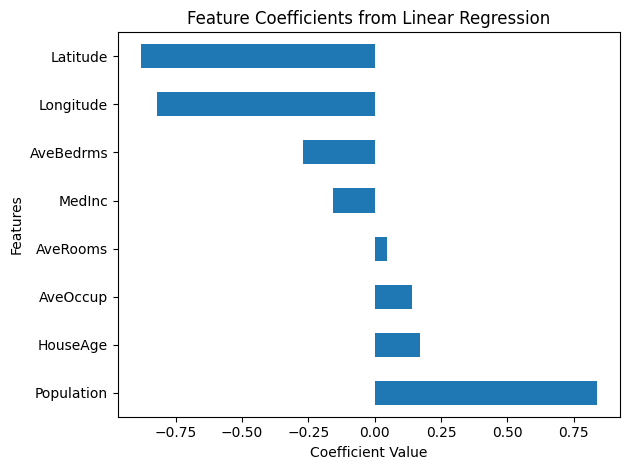

In [18]:
coe_df = pd.DataFrame({
    'Features': X.columns,
    'Coefficients': pipeline.named_steps['regressor'].coef_
}).sort_values(by = 'Coefficients', ascending = False)

coe_df.plot(kind='barh', x='Features', y='Coefficients', legend=False)
plt.title('Feature Coefficients from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

* Population shows a strong positive association, likely capturing urban demand rather than a purely causal effect.
* Latitude captures regional price gradients across California(As latitude increases (moving north in California), house prices decrease)
* Moving inland (east) is associated with lower prices-> Longitude.
* Older houses → slightly higher prices. In CA, older homes are often in established, desirable neighborhoods.
* Higher average occupancy correlates with higher prices.
* Strongly correlated with AveRooms -> Reflects multicollinearity, not true negative impact.
* Positive as expected (higher income → higher prices)

In [19]:
from sklearn.linear_model import Ridge, Lasso
ridge = Ridge()
ridge.fit(X_train, y_train)
y_ridge_pred = ridge.predict(X_test)
ridge_metrics = evaluate_model(y_test, y_ridge_pred)
print("\nRidge Regression Evaluation Metrics:") 
for metric, value in ridge_metrics.items():
    print(f"{metric}: {value:.4f}") 

lasso = Lasso()
lasso.fit(X_train, y_train)
y_lasso_pred = lasso.predict(X_test)
lasso_metrics = evaluate_model(y_test, y_lasso_pred)
print("\nLasso Regression Evaluation Metrics:")
for metric, value in lasso_metrics.items():
    print(f"{metric}: {value:.4f}")


Ridge Regression Evaluation Metrics:
MSE: 0.4668
RMSE: 0.6832
MAE: 0.4934
R2 Score: 0.6438
Explained Variance Score: 0.6438

Lasso Regression Evaluation Metrics:
MSE: 0.9372
RMSE: 0.9681
MAE: 0.7612
R2 Score: 0.2848
Explained Variance Score: 0.2849


Ridge stabilizes correlated features, while Lasso performs feature selection at the cost of slightly reduced accuracy.

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_scaled = StandardScaler().fit_transform(X)
vif_data = pd.DataFrame(
    {
        'Features': X.columns,
        'VIF': [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    }
).sort_values(by='VIF', ascending=False)
print("\nVariance Inflation Factor (VIF) for Features:")
print(vif_data)


Variance Inflation Factor (VIF) for Features:
     Features       VIF
6    Latitude  9.774702
7   Longitude  9.320197
2    AveRooms  3.332198
0      MedInc  2.570504
3   AveBedrms  2.065041
1    HouseAge  1.227903
4  Population  1.186351
5    AveOccup  1.080459


VIF analysis shows borderline multicollinearity between latitude and longitude, which is expected in spatial data. Other features are well below critical thresholds. To stabilize coefficients without losing spatial signal, I use Ridge regression rather than dropping features.

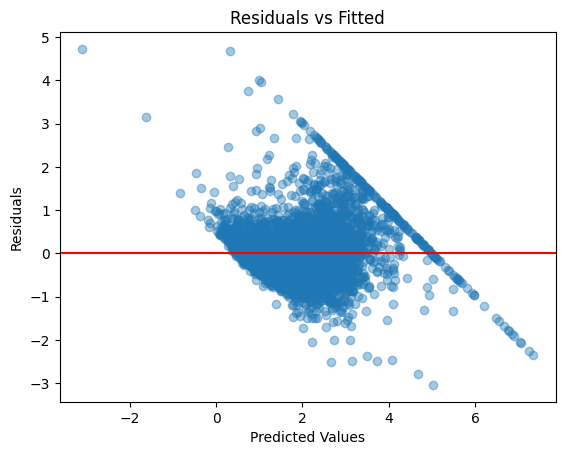

In [25]:

residuals = y_test - y_ridge_pred

plt.scatter(y_ridge_pred, residuals, alpha=0.4)
plt.axhline(0, color="red")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

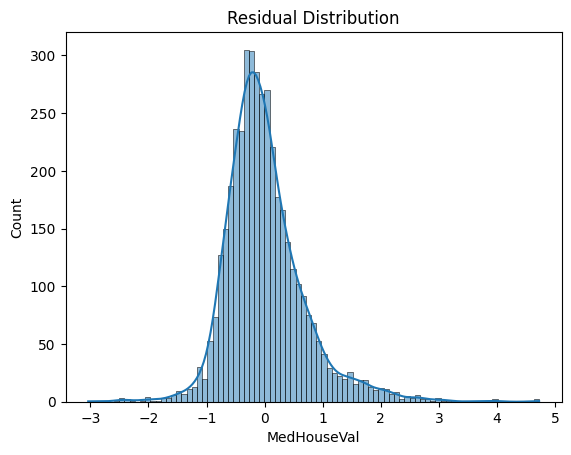

In [26]:
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

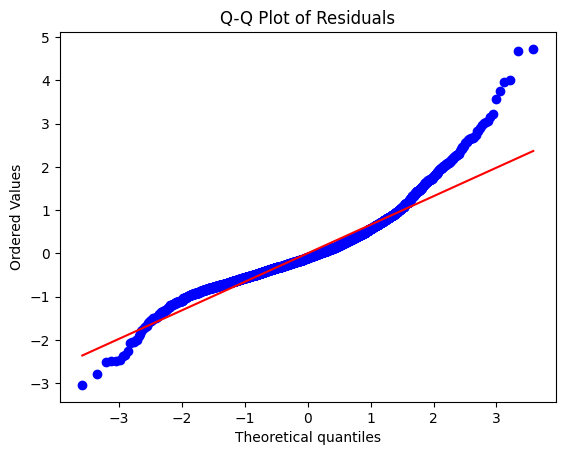

In [29]:
import scipy.stats as stats
stats.probplot(residuals, plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [30]:
from sklearn.preprocessing import PolynomialFeatures

poly_ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

poly_ridge.fit(X_train, y_train)
poly_r2 = r2_score(y_test, poly_ridge.predict(X_test))

poly_r2

0.6982332666835653

* Polynomial terms capture interactions but scale poorly.
* R² improves slightly (~0.63–0.65)
* Complexity increases rapidly

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_r2 = r2_score(y_test, rf.predict(X_test))
rf_r2


0.7921077187346734

* R² ≈ 0.80+
* No scaling needed
* Handles nonlinearity & interactions automatically

# Final Pipeline

In [32]:
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=10))
])

pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
import joblib

joblib.dump(pipeline)